# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import scipy as sp
from tqdm import tqdm
import os
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from sklearn import datasets, neighbors
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [155]:
# using SQLite Table to read data.
con = sqlite3.connect('C:\Python\Amazon review\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(1)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [156]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [157]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [158]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [159]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [160]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [161]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

In [162]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [163]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [164]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████| 364171/364171 [03:18<00:00, 1831.63it/s]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [165]:
## Similartly you can do preprocessing for review summary also.
preprocessed_sum = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_sum.append(sentance.strip())

100%|████████████████████████████████| 364171/364171 [02:05<00:00, 2890.64it/s]


In [166]:
# adding the new preprocessed data as new columns to our final dataframe.

ps = pd.Series(preprocessed_sum)
final['Summary_new']=ps.values

pr = pd.Series(preprocessed_reviews)
final['Text_new']=pr.values

print('Shape of final',final.shape)
print(final['Score'].value_counts())
final.head(1)

Shape of final (364171, 12)
1    307061
0     57110
Name: Score, dtype: int64


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Summary_new,Text_new
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,every book educational,witty little book makes son laugh loud recite ...


In [167]:
# Saving the final data frame, prerocessed reviews and summary, 
# so that we can resume directly from here without doing preprocessing again
# https://www.datacamp.com/community/tutorials/reading-writing-files-python

with open("final.txt", "wb") as file:
    pickle.dump(final, file)
    
with open("preprocessed_reviews.txt", "wb") as file:
    pickle.dump(preprocessed_reviews, file)
    
with open("preprocessed_summary.txt", "wb") as file:
    pickle.dump(preprocessed_sum, file)

# [4] Featurization

 BAG OF WORDS, Bi-Grams and n-Grams, TF-IDF, Word2Vec, Converting text into vectors using wAvg W2V, TFIDF-W2V, Avg W2v, TFIDF weighted W2v


## Splitting of data set

In [342]:
sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [343]:
with open("final_sorted.txt", "wb") as file:
    pickle.dump(sorted_data, file)

### <font color='red'> Loading already saved sorted data, so that i don't have to do it agin

In [2]:
with open("final_sorted.txt", "rb") as file:
    sorted_data = pickle.load(file)

In [3]:
my_final = sorted_data[:50000]
print(my_final.shape)
my_final.head(1)

(50000, 12)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Summary_new,Text_new
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,every book educational,witty little book makes son laugh loud recite ...


In [4]:
my_final['Score'].value_counts()

1    44376
0     5624
Name: Score, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split


x = my_final['Text_new'].values
y = my_final['Score']


# split the data set into train and test
X_1, X_test, y_1, Y_test = cross_validation.train_test_split(x, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_train, X_cv, Y_train, Y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3,random_state=0)

In [6]:
#https://stackoverflow.com/questions/10741346/numpy-most-efficient-frequency-counts-for-unique-values-in-an-array
# Printing the frequency of positive and negative values in Train, CV and Test data set
unique, counts = np.unique(Y_train, return_counts=True)

np.asarray((unique, counts)).T

array([[    0,  2756],
       [    1, 21744]], dtype=int64)

In [7]:
unique, counts = np.unique(Y_test, return_counts=True)

np.asarray((unique, counts)).T

array([[    0,  1673],
       [    1, 13327]], dtype=int64)

In [8]:
unique, counts = np.unique(Y_cv, return_counts=True)

np.asarray((unique, counts)).T

array([[   0, 1195],
       [   1, 9305]], dtype=int64)

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force with 50k Sample

## <font color='red'> Function for implementation

In [9]:
def knn_all(X_train_vec, X_test_vec, X_cv_vec, Y_cv, Y_test, Y_train, algo):
    '''
    This function takes Train, CV, and Test dataset, and computes all the required steps for the assignment completely.
    '''
    #Normalizing the data
    std_train = normalize(X_train_vec)
    std_cv = normalize(X_cv_vec)
    std_test = normalize(X_test_vec)
    print("\nFinished Normalization\n\n")
    
    #Calculation knn for different k values
    auc_train = []
    auc_cv = []
    print("Starting classifier...")
    for i in tqdm(range(1,50,2)):
        knn = neighbors.KNeighborsClassifier(n_neighbors=i, algorithm=algo)#,n_jobs=-1)
        knn.fit(std_train,Y_train)

        pred_prob = knn.predict_proba(std_cv)
        pred_prob_train = knn.predict_proba(std_train)
        
        #acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
        auc_cv.append(roc_auc_score(Y_cv, pred_prob[:,1]))
        auc_train.append(roc_auc_score(Y_train, pred_prob_train[:,1]))
        #print(i)

    '''
    #GridSearchCV with default 3 fold
    knn = neighbors.KNeighborsClassifier(n_neighbors=i, algorithm=algo,n_jobs=-1)

    param_grid = {'n_neighbors':np.arange(1,50,2)}
    gsv = GridSearchCV(knn,param_grid, verbose=1,n_jobs=-1, scoring='roc_auc')
    gsv.fit(std_train,Y_train)
    print("Best HyperParameter: ",gsv.best_params_)
    print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
    #print("\nDone predicting for different k-values.\n\n")

    '''

    #Plotting the AUC curve for train and test data
    
    #Print the graph
    k = np.arange(1,50,2)
    plt.plot(k,auc_train,'r', label = 'Train Data')
    plt.plot(k,auc_cv,'b', label = 'CV Data')
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.title("AUC Values for Train and CV Data\n")
    plt.xlabel("Hyper Parameter(K)")
    plt.ylabel("AUC Value")
    plt.show()
    
    
    #Get k value for max auc in cv data
    mx = 0
    for i in range(len(auc_cv)):
        if(auc_cv[i]> auc_cv[mx]):
            mx = i
    opt_k = mx*2 + 1  #Since i have taken odd k values from 1 to 100
    print("The optimal value of k = ", opt_k)
    
    #Applying on test data
    print("\nClassifying Test Data\n\n")
    knn = KNeighborsClassifier(opt_k)
    knn.fit(X_train_vec,Y_train)

    pred = knn.predict(X_test_vec)
    pred_prob = knn.predict_proba(X_test_vec)

    #pred_train = knn.predict(X_train_vec)
    pred_prob_train = knn.predict_proba(X_train_vec)

    #ROC Values comutation
    fpr, tpr, threshold = roc_curve(Y_train, pred_prob_train[:,1])
    fpr1, tpr1, threshold1 = roc_curve(Y_test, pred_prob[:,1])
    print("The AUC value for test data is ",roc_auc_score(Y_test, pred_prob[:,1]))

    plt.plot(fpr,tpr,'r', label = 'Train Data')
    plt.plot(fpr1,tpr1,'b', label = 'Test Data')
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.title("ROC Curve for Train and Test Data\n")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    
    #Confusion Matrix
    cm = confusion_matrix(Y_test,pred)
    tn, fp, fn, tp = cm.ravel()
    
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
    class_names = ['0','1']
    df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
    fig = plt.figure(figsize=(5,3))
    heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

    # Setting tick labels for heatmap
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('True label',size=18)
    plt.xlabel('Predict label',size=18)
    plt.title("Confusion Matrix\n",size=24)
    plt.show()

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [10]:
# Please write all the code with proper documentation
# Bag of Words
count_vect = CountVectorizer() #in scikit-learn
s1_train_vec = count_vect.fit_transform(X_train)
s1_test_vec = count_vect.transform(X_test)
s1_cv_vec = count_vect.transform(X_cv)
print("the type of count vectorizer :",type(s1_train_vec))
print("the shape of out text BOW vectorizer : ",s1_train_vec.get_shape())
print("the number of unique words :", s1_train_vec.get_shape()[1])


the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (24500, 30172)
the number of unique words : 30172



Finished Normalization


Starting classifier...


100%|██████████████████████████████████████████| 25/25 [16:47<00:00, 41.74s/it]


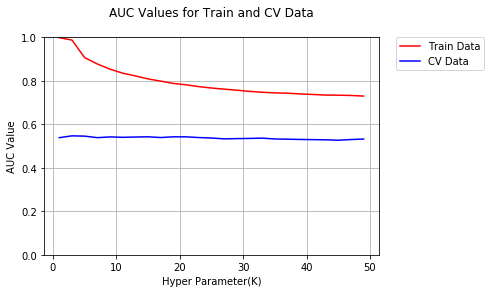

The optimal value of k =  3

Classifying Test Data


The AUC value for test data is  0.6372108341420334


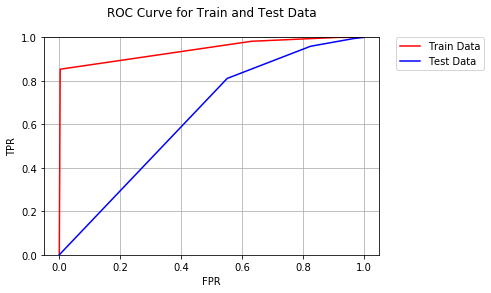

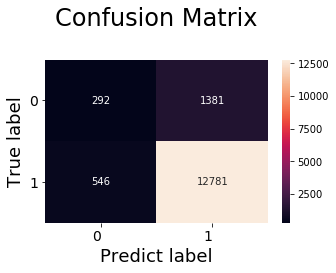

In [11]:
knn_all(s1_train_vec, s1_test_vec, s1_cv_vec, Y_cv, Y_test, Y_train, 'brute')

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [12]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)

final_tf_idf = tf_idf_vect.fit_transform(X_train)

s2_train_vec = tf_idf_vect.fit_transform(X_train)
s2_test_vec = tf_idf_vect.transform(X_test)
s2_cv_vec = tf_idf_vect.transform(X_cv)
print("the type of count vectorizer ",type(s2_train_vec))
print("the shape of out text TFIDF vectorizer ",s2_train_vec.get_shape())
print("the number of unique words including both unigrams and bigrams ", s2_train_vec.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (24500, 13726)
the number of unique words including both unigrams and bigrams  13726



Finished Normalization


Starting classifier...


100%|██████████████████████████████████████████| 25/25 [16:25<00:00, 39.99s/it]


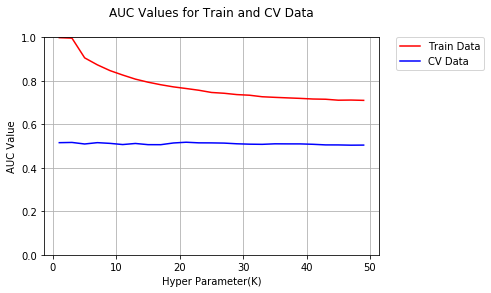

The optimal value of k =  21

Classifying Test Data


The AUC value for test data is  0.499678441102919


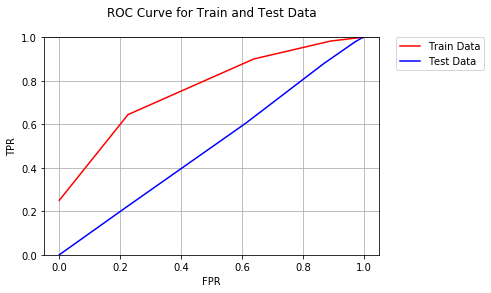

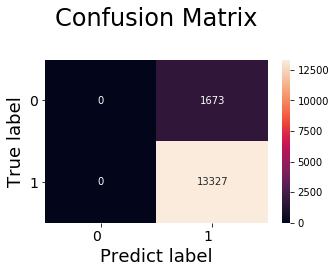

In [13]:
knn_all(s2_train_vec, s2_test_vec, s2_cv_vec, Y_cv, Y_test, Y_train, 'brute')

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [14]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

 # min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))


number of words that occured minimum 5 times  9608


In [15]:
 def avgwtv(X_test):
    '''
    returns average woed2vec
    '''
    i=0
    list_of_sentance=[]
    for sentance in X_test:
        list_of_sentance.append(sentance.split())
    test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        test_vectors.append(sent_vec)
    return test_vectors

In [16]:
s3_train_vectors = avgwtv(X_train)
s3_cv_vectors = avgwtv(X_cv)
s3_test_vectors = avgwtv(X_test)

100%|███████████████████████████████████| 15000/15000 [00:29<00:00, 514.60it/s]



Finished Normalization


Starting classifier...


100%|██████████████████████████████████████████| 25/25 [11:56<00:00, 28.00s/it]


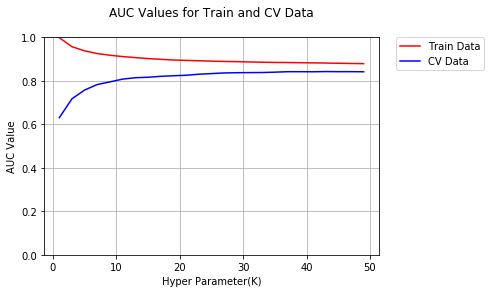

The optimal value of k =  43

Classifying Test Data


The AUC value for test data is  0.8455846548030816


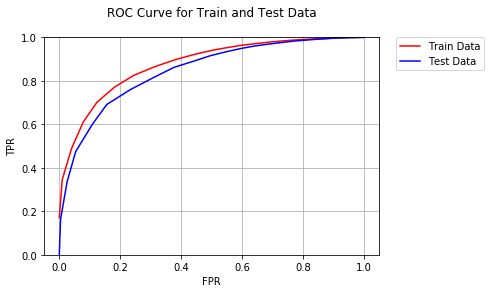

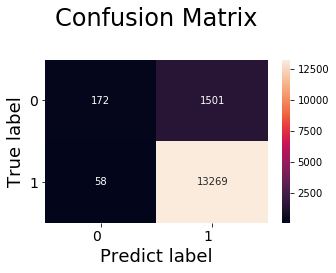

In [17]:
knn_all(s3_train_vectors, s3_test_vectors, s3_cv_vectors, Y_cv, Y_test, Y_train, 'brute')

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [18]:
# Please write all the code with proper documentation
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

#standardized_weight_w2v = StandardScaler().fit_transform(tfidf_sent_vectors)
#print(standardized_weight_w2v.shape)

In [19]:
def tfidfw2v(test):
    '''
    Returns tfidf word2vec
    '''
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    i=0
    list_of_sentance=[]
    for sentance in test:
        list_of_sentance.append(sentance.split())
        
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
     
    return tfidf_sent_vectors
        

In [20]:
s4_train_vectors1 = tfidfw2v(X_train)
s4_cv_vectors1 = tfidfw2v(X_cv)
s4_test_vectors1 = tfidfw2v(X_test)

100%|████████████████████████████████████| 15000/15000 [04:43<00:00, 50.64it/s]



Finished Normalization


Starting classifier...


100%|██████████████████████████████████████████| 25/25 [11:32<00:00, 28.29s/it]


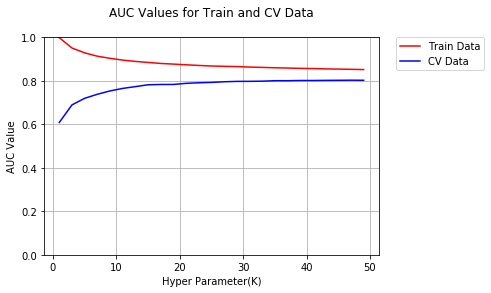

The optimal value of k =  47

Classifying Test Data


The AUC value for test data is  0.8107695297525739


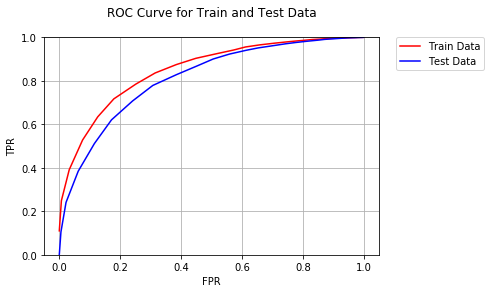

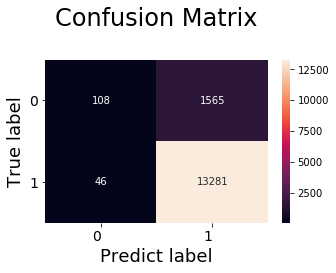

In [21]:
knn_all(s4_train_vectors1, s4_test_vectors1, s4_cv_vectors1, Y_cv, Y_test, Y_train, 'brute')

## [5.2] Applying KNN kd-tree with 20k sample


### <font color='red'> Loading already saved sorted data, so that i don't have to do it agin

In [22]:
with open("final_sorted.txt", "rb") as file:
    sorted_data = pickle.load(file)

In [23]:
my_final = sorted_data[:20000]
print(my_final.shape)
my_final.head(1)

(20000, 12)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Summary_new,Text_new
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,every book educational,witty little book makes son laugh loud recite ...


In [24]:
from sklearn.model_selection import train_test_split


x = my_final['Text_new'].values
y = my_final['Score']


# split the data set into train and test
X_1, X_test, y_1, Y_test = cross_validation.train_test_split(x, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_train, X_cv, Y_train, Y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3,random_state=0)

In [25]:
#https://stackoverflow.com/questions/10741346/numpy-most-efficient-frequency-counts-for-unique-values-in-an-array
# Printing the frequency of positive and negative values in Train, CV and Test data set
unique, counts = np.unique(Y_train, return_counts=True)

np.asarray((unique, counts)).T

array([[   0, 1031],
       [   1, 8769]], dtype=int64)

In [26]:
unique, counts = np.unique(Y_test, return_counts=True)

np.asarray((unique, counts)).T

array([[   0,  667],
       [   1, 5333]], dtype=int64)

In [27]:
unique, counts = np.unique(Y_cv, return_counts=True)

np.asarray((unique, counts)).T

array([[   0,  476],
       [   1, 3724]], dtype=int64)

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [28]:
# Please write all the code with proper documentation
count_vect = CountVectorizer(min_df=10, max_features=500)  #in scikit-learn
s5_train_vec = count_vect.fit_transform(X_train)
s5_test_vec = count_vect.transform(X_test)
s5_cv_vec = count_vect.transform(X_cv)
print("the number of unique words :", s5_train_vec.get_shape()[1])

the number of unique words : 500



Finished Normalization


Starting classifier...


100%|█████████████████████████████████████████| 25/25 [58:43<00:00, 134.00s/it]


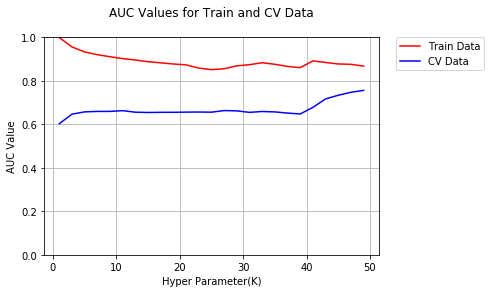

The optimal value of k =  49

Classifying Test Data


The AUC value for test data is  0.7187612362954096


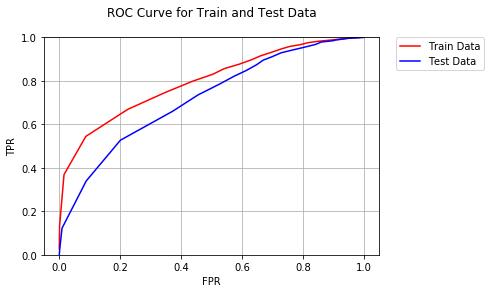

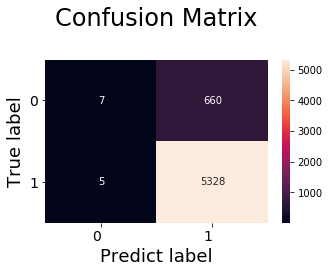

In [29]:
knn_all(s5_train_vec.toarray(), s5_test_vec.toarray(), s5_cv_vec.toarray(), Y_cv, Y_test, Y_train, 'kd_tree')

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [33]:
# Please write all the code with proper documentation

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,  max_features=500)

final_tf_idf = tf_idf_vect.fit_transform(X_train)

s6_train_vec = tf_idf_vect.fit_transform(X_train)
s6_test_vec = tf_idf_vect.transform(X_test)
s6_cv_vec = tf_idf_vect.transform(X_cv)
print("the number of unique words including both unigrams and bigrams ", s6_train_vec.get_shape()[1])


the number of unique words including both unigrams and bigrams  500



Finished Normalization


Starting classifier...


100%|██████████████████████████████████████████| 25/25 [20:24<00:00, 49.65s/it]


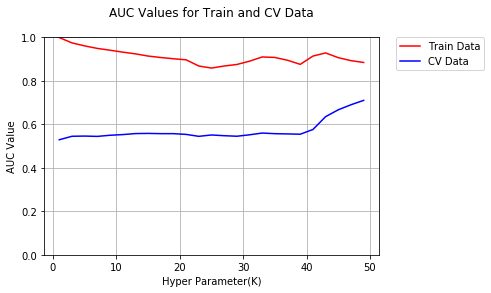

The optimal value of k =  47

Classifying Test Data


The AUC value for test data is  0.6959839037915881


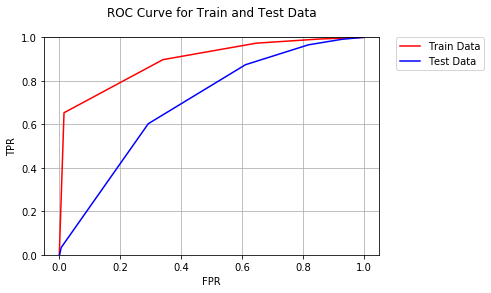

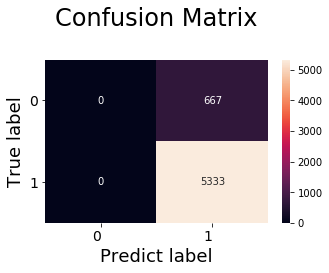

In [34]:
knn_all(s6_train_vec.toarray(), s6_test_vec.toarray(), s6_cv_vec.toarray(), Y_cv, Y_test, Y_train, 'kd_tree')

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>


Finished Normalization


Starting classifier...


100%|██████████████████████████████████████████| 25/25 [01:47<00:00,  5.17s/it]


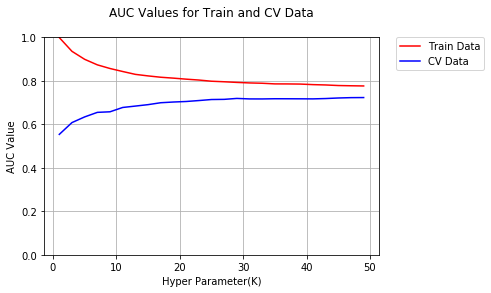

The optimal value of k =  47

Classifying Test Data


The AUC value for test data is  0.7279190893958608


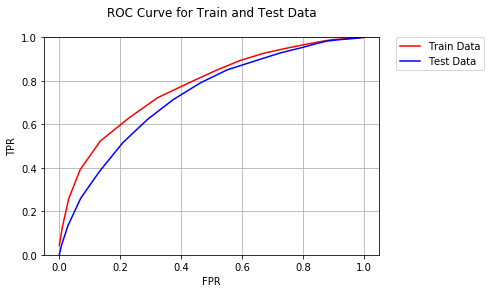

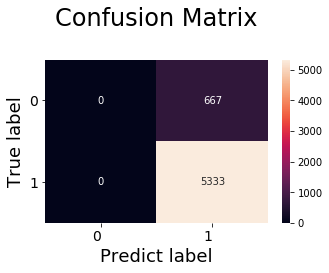

In [35]:
knn_all(s3_train_vectors, s3_test_vectors, s3_cv_vectors, Y_cv, Y_test, Y_train,'kd_tree')

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>


Finished Normalization


Starting classifier...


100%|██████████████████████████████████████████| 25/25 [01:33<00:00,  4.40s/it]


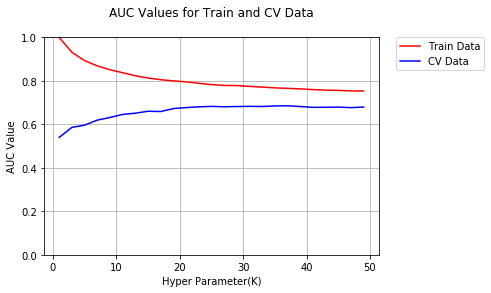

The optimal value of k =  35

Classifying Test Data


The AUC value for test data is  0.6982786030573688


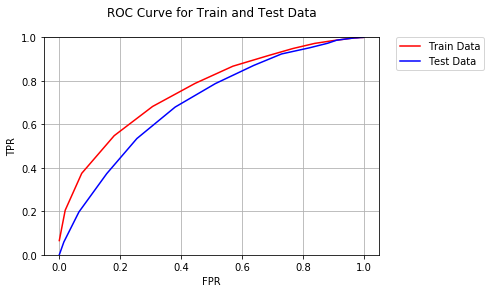

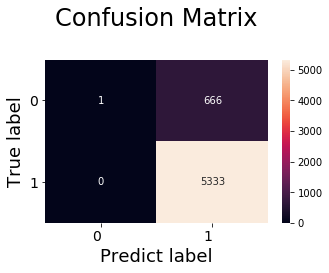

In [36]:
knn_all(s4_train_vectors1, s4_test_vectors1, s4_cv_vectors1, Y_cv, Y_test, Y_train, 'kd_tree')

# [6] Conclusions

In [30]:
from prettytable import from_csv
with open("table.csv", "r") as fp: 
    x = from_csv(fp)
    
print(x)

+------------+---------+-----------------+------+
| Vectorizer |  Model  | Hyper Parameter | AUC  |
+------------+---------+-----------------+------+
|    BOW     |  Brute  |        3        | 0.64 |
|   TFIDF    |  Brute  |        21       | 0.5  |
|  AVG W2V   |  Brute  |        43       | 0.85 |
| TFIDF W2V  |  Brute  |        47       | 0.81 |
|    BOW     | KD_Tree |        49       | 0.72 |
|   TFIDF    | KD_Tree |        47       | 0.69 |
|  AVG W2V   | KD_Tree |        47       | 0.72 |
| TFIDF W2V  | KD_Tree |        35       | 0.7  |
+------------+---------+-----------------+------+


1. From the above table, we can say that, both brute force and KD Tree implementation give similar results for this dataset.
2. I got a maximum AUC value I got was 0.77 for Avg W2V brute force, but others also gave similar values.
3. The major problem we observed in all the implementation is that very few data points got classified as negative class. Ihe highly imbalanced dataset is one of the reason for that as we know AUC values are sensitive to imbalanced datasets.
4. So KNN is not a suitable classifier for this dataset with 20k points.